In [1]:
import scipy.io
import scipy.spatial
import scipy.interpolate
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
import os

import numpy as np

import datafold.dynfold as dfold
import datafold.pcfold as pfold
import datafold.utils

import sklearn

import pandas as pd

from os import listdir
from os.path import isfile, join

from large_eigensystems import *
from test_efficiency import *

In [2]:
n_pts = 10000
cknn_k_neighbor = 50
random_seed = 1
n_eigenvectors = 2000
kernel_tol = 1e-16
evec_tol = 1e-8

def sensor1(_z,_eps):
    _z = _z+0.5
    _eps = _eps+0.5
    return np.column_stack([
        (3/2 * _eps + _z /3 + 2/3) *np.cos(4*np.pi*_eps),
        (3/2 * _eps + _z /3 + 2/3) *np.sin(4*np.pi*_eps)
    ])
def sensor2(_z,_nu):
    _z = _z+0.5
    _nu = _nu+0.5
    return np.column_stack([
        (1+1/3*np.cos(2*np.pi*_z))*np.cos(2*np.pi*_nu),
        (1+1/3*np.cos(2*np.pi*_z))*np.sin(2*np.pi*_nu),
        1/3*np.sin(2*np.pi*_z)
    ])
def get_peff(x,y,z): return x[:,0];# = lambda x,y,z: x

_te = TestEfficiency(sensor1, sensor2, n_pts=n_pts,cknn_k_neighbor=cknn_k_neighbor,
                     random_seed=random_seed, verbose=True, n_kernel_evecs=n_eigenvectors, kernel_tol=kernel_tol, 
                     evec_tol=evec_tol, cutoff_result_scaling=1,
                     get_peff=get_peff, kernel_type="gaussian")
evals_c, evecs_c = _te.compute_common_system()

data_sensor1, data_sensor2, peff = _te.setup_example()

Time for kernel 1: 0.7167196273803711
Sparsity of kernel 1: 1.104918 percent
Time for kernel 2: 0.547091007232666
Sparsity of kernel 2: 0.537954 percent
computing first eigensystem... done
computing second eigensystem... done
Time for sparse SVD 20.348658800125122


In [3]:
# manifold learning of the common eigenfunctions
pcm = pfold.PCManifold(evecs_c[:,:5])
print(pcm.shape)
pcm.optimize_parameters(result_scaling=3)
#pcm.kernel.epsilon = 1e-2
#pcm.kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=50, delta=1)

print(f"Parameters: cutoff={pcm.cut_off}, epsilon={pcm.kernel.epsilon}")

dmaps = dfold.DiffusionMaps(kernel=pcm.kernel, n_eigenpairs=5, dist_kwargs={"backend": "scipy.kdtree", "cut_off": pcm.cut_off})
dmaps.fit(pcm)


(10000, 5)
Parameters: cutoff=0.006647439978751235, epsilon=2.3988504488688668e-06


DiffusionMaps(dist_kwargs={'backend': 'scipy.kdtree',
                           'cut_off': 0.006647439978751235},
              kernel=GaussianKernel(epsilon=2.3988504488688668e-06),
              n_eigenpairs=5)

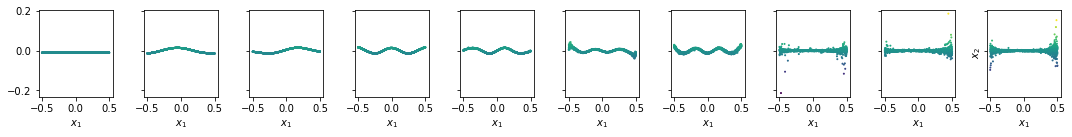

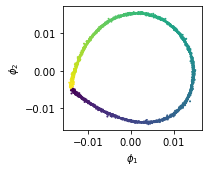

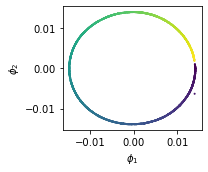

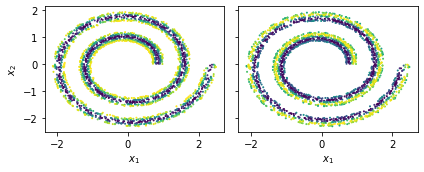

In [5]:
fig,ax = plt.subplots(1,evecs_c.shape[1],figsize=(15,2),sharey=True)

vmin,vmax = np.min(evecs_c)/3, np.max(evecs_c)/3

n_plot_pts = 2500
marker_size = 1

for k in range(evecs_c.shape[1]):
    #ax[k].scatter(*data_sensor1[:n_plot_pts,:2].T, vmin=vmin,vmax=vmax, s=marker_size, c=evecs_c[:n_plot_pts,k], )
    ax[k].scatter(peff[:n_plot_pts],evecs_c[:n_plot_pts,k], vmin=vmin,vmax=vmax, s=marker_size, c=evecs_c[:n_plot_pts,k], )
    ax[k].set_xlabel(r"$x_1$")
    if k == evecs_c.shape[1]-1:
        ax[k].set_ylabel(r"$x_2$")

fig.tight_layout()

fig.savefig("figures/simple_positions_evecs.pdf")

fig,ax = plt.subplots(1,1,figsize=(3,2.5))
ax.scatter(*evecs_c[:n_plot_pts,[1,2]].T, s=marker_size, c=peff[:n_plot_pts,], )
ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

fig.tight_layout()
fig.savefig("figures/simple_evecs_c_positions.pdf")

fig,ax = plt.subplots(1,1,figsize=(3,2.5))
ax.scatter(*dmaps.eigenvectors_[:n_plot_pts,[1,2]].T, s=marker_size, c=peff[:n_plot_pts,], )
ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

fig.tight_layout()
fig.savefig("figures/simple_evecs_positions.pdf")

fig,ax = plt.subplots(1,2,figsize=(6,2.5),sharey=True)
ax[0].scatter(*data_sensor1[:n_plot_pts,:2].T, s=marker_size, c=dmaps.eigenvectors_[:n_plot_pts,1], )
ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$x_2$")
ax[1].scatter(*data_sensor1[:n_plot_pts,:2].T, s=marker_size, c=dmaps.eigenvectors_[:n_plot_pts,2], )
ax[1].set_xlabel(r"$x_1$")

fig.tight_layout()
fig.savefig("figures/simple_positions_dmaps.pdf")